# Parse the TFRecord file

## 匯入相關函式庫 Import all the necessary libraries

In [1]:
import os
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 

%matplotlib inline

tf.__version__

'2.0.0'

## Load the tf.data.Dataset from TFRecord files

In [2]:
raw_train_dataset = tf.data.TFRecordDataset('../data/train_voc.tfrecord')
raw_train_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

## Parse the TFRecord file

In [3]:
for raw_train_data in raw_train_dataset.take(1):    
    example = tf.train.Example()
    example.ParseFromString(raw_train_data.numpy())  
    #print(example)

In [4]:
# Create a dictionary describing the features.
image_feature_description = {
    'filename': tf.io.FixedLenFeature([], tf.string),
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'classes': tf.io.VarLenFeature(tf.int64),
    'x_mins': tf.io.VarLenFeature(tf.float32),
    'y_mins': tf.io.VarLenFeature(tf.float32),
    'x_maxes': tf.io.VarLenFeature(tf.float32),
    'y_maxes': tf.io.VarLenFeature(tf.float32),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def parse_tf_example(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.io.parse_single_example(example_proto, image_feature_description)
    
    x_train = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)
    x_train = tf.image.resize(x_train, (416, 416)) # yolov2 - input size
    x_train /= 255.
    
    labels = tf.sparse.to_dense(parsed_example['classes'])
    labels = tf.cast(labels, tf.float32)
    
    xmin = tf.sparse.to_dense(parsed_example['x_mins'])
    ymin = tf.sparse.to_dense(parsed_example['y_mins'])
    xmax = tf.sparse.to_dense(parsed_example['x_maxes'])
    ymax = tf.sparse.to_dense(parsed_example['y_maxes'])
    
    y_train = tf.stack([xmin,ymin,
                        xmax,ymax,
                        labels], axis=1)
    
    filename = parsed_example['filename']
    
    return filename, x_train, y_train

train_dataset = raw_train_dataset.map(parse_tf_example)
train_dataset

<MapDataset shapes: ((), (416, 416, 3), (None, 5)), types: (tf.string, tf.float32, tf.float32)>

## Show images from the dataset

W1004 13:06:39.643568 140624096937792 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1004 13:06:39.664391 140624096937792 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1004 13:06:39.684968 140624096937792 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


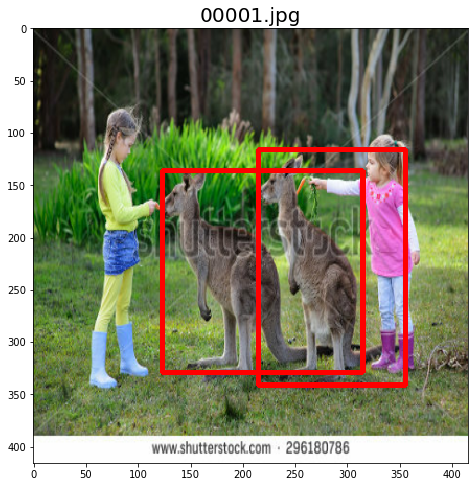

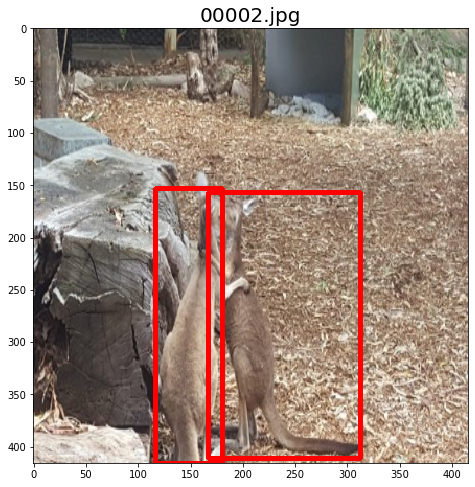

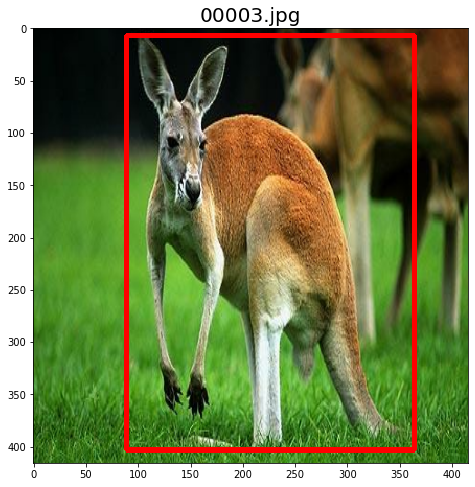

In [5]:
for f, x, y in train_dataset.take(3):
    img = x.numpy()
    boxes = y.numpy()
    filename = f.numpy().decode()

    for box in boxes:
        left = (box[0] * 416).astype('int32')
        top = (box[1] * 416).astype('int32')
        right = (box[2] * 416).astype('int32')
        bottom = (box[3] * 416).astype('int32')
    
        # cv2.rectangle(image, (left, top), (right, bottom), color, thickness)
        cv2.rectangle(img, (left, top), (right, bottom), (255, 0, 0), 3)
    
    f, (ax1) = plt.subplots(1, 1, figsize=(8,8))
    f.subplots_adjust(hspace = .2, wspace = .05)
    
    ax1.imshow(img)
    ax1.set_title('{}'.format(filename), fontsize=20)